# LOAD STUFF

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines
from scipy.io import readsav
from scipy import ndimage
import matplotlib.transforms as mtransforms
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
# import math
import glob as glob
import seaborn as sns

# PyMC 4.0 imports
import pymc as pm
import aesara.tensor as at 
import aesara
import arviz as az
import pymc.sampling_jax
import pytensor.tensor as pt
import pytensor

import sys
sys.path.append('../')

from scipy import stats

import os

from funciones.opencube2 import opencube2
from funciones.func4 import tilt,elong,MFLUX,barys,set_ranges,sizes,sizes2
from funciones.modelcube import modelmag,modelmagf,modelmag2


/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


# Compute DATAFRAMES

In [2]:
name=9290

In [3]:
tilta = []
tiltb = []

lower_lim = 0.5
DFx = []

time_grid = np.linspace(0, 1.0, 11)  # Grilla común

#for name in ars2:
DF=pd.read_csv('compare-params-TM3-C.csv')
    
DF2 = DF[DF.AR == name]

#if DF2.fint.min() >= lower_lim:
#    print(f"Región {name} no llega a f_norm = {lower_lim}, se excluye.")
#    continue

lower_lim =   DF2.fint.min()+0.2
# Normalización basada en el valor de mag en el punto de máximo flujo normalizado
idx_max = DF2.fint.idxmax()
magmax = DF2.loc[idx_max].mag

# (opcional) linealizar si se desea ajustar f_norm como función de mag/magmax
DF2p = DF2[DF2.fint < lower_lim]
x_pre = DF2p.mag.values / magmax
y_pre = DF2p.fint.values

slope, intercept, _, _, _ = stats.linregress(y_pre, x_pre)

# Definir eje de tiempo normalizado
t_norm = (DF2.mag.values - intercept) / (magmax - intercept)

if intercept >0:
    print(f'AR {name} t_norm 0 is lower than 0 ***{intercept}***')
    plt.plot(y_pre,x_pre)
    plt.plot(np.arange(0,0.2,0.1),slope*np.arange(0,0.2,0.1)+intercept,color='r')
    plt.show()
    
    
#   DFx.append(pd.DataFrame({'AR':name,'fn':int_fn(time_grid),
#                            'alpha':int_alpha(time_grid),'alphab':int_alphab(time_grid),'t_grid':time_grid,'t_norm':np.linspace(0,1,11),'lat':DF2.lat.mean()}))
tilta.append(DF2.alpha.values)
tiltb.append(DF2.alphab.values)

DFx.append(pd.DataFrame({'AR':name,'alpha':DF2.alpha.values,'alphab':DF2.alphab.values,'t_norm':t_norm,
                            'lat':DF2.lat.mean(),'fn':DF2.fint.values,'mag':DF2.mag.values,'flux':DF2.flux.values}))

DFx=pd.concat(DFx)

In [4]:
try:
    try:
        DF1=pd.read_csv('./posteriors3/'+str(name)+'_TM3.csv')
    except Exception as e:
        print(f'{name} not found in posterior 3')
        DF1=pd.read_csv('./posteriors2/'+str(name)+'_TM3.csv')
    nn=int(DF1.mag.max())   
    datad = np.transpose(np.load(f'../newdat/{name}_cube_data.npy'),axes=(1,2,0))[:,:,0:nn+1]
    mask_cube= np.load(f'./masks2/mask_{name}.npy')[:,:,0:nn+1]
    stp=round(nn/len(set(DF1.mag)))
    thr=0
except Exception as e:
    try:
        DF1=pd.read_csv('./posteriors3/'+str(name)+'_TM3.csv')
    except Exception as e:
        print(f"Error processing {name}: {str(e)}")
        DF1=pd.read_csv('./posteriors/'+str(name)+'_TM3.csv')
       
    datad,times=opencube2(name=str(name),path='../movies')
    datad=datad[:,:,0:nn]
    mask_cube=np.load('./masks/'+str(name)+'_mask.npy')[:,:,0:nn]
    stp=round(nn/DF1.mag.max())
    DF1=DF1.assign(mag=lambda x: x.mag*stp)
    thr=20
    #continue
    




scl=1


#   nn=DF0[DF0['AR']==name].range.values[0]
#   sg0=DF0[DF0['AR']==name].sigma.values[0]


data2=datad*mask_cube
sz2,sz1,nMagnetograms = (np.shape(data2))

print(sz2,sz1,nMagnetograms)

mmed=[]
for i in range(nMagnetograms):
    absdat=np.abs(data2[:,:,i])
    mmed.append(np.median(absdat[absdat>0]))


# thr=10

tl=[[tilt(data2[:,:,i]*hh,thr)[0]*180/np.pi for hh in [np.abs(data2[:,:,i])>0,
                                                       np.abs(data2[:,:,i])>mmed[i],
                                                       np.abs(data2[:,:,i])>2*mmed[i],
                                                       np.abs(data2[:,:,i])>3*mmed[i]]] for i in range(nMagnetograms)]
flux=np.sum(np.abs(data2)*(np.abs(data2)>thr)/2,axis=(0,1))
fln=flux/np.max(flux)

#tl=[tilt(data2[:,:,i],thr)[0]*180/np.pi for i in range(nMagnetograms)]


9290 not found in posterior 3
65 131 75


In [5]:
tl_df = pd.DataFrame({
    'mag': np.arange(len(tl))[::stp],
    'tl_0': [-1*v[0] for v in tl][::stp],
    'tl_1': [-1*v[1] for v in tl][::stp],
    'tl_2': [-1*v[2] for v in tl][::stp],
    'tl_3': [-1*v[3] for v in tl][::stp],
    'flux':fln[::stp]
})

In [6]:
DF1 = DF1.merge(DFx[['mag', 't_norm']], on='mag', how='left')

In [7]:
tl_df = tl_df.merge(DFx[['mag', 't_norm']], on='mag', how='left')
tl_df=pd.melt(tl_df,id_vars=['mag','t_norm','flux'],value_vars=['tl_0','tl_1','tl_2','tl_3'])

In [8]:
DF1['alpha']=DF1.apply(lambda x: -1*180*x.alpha/np.pi,axis=1)

# PLOTS

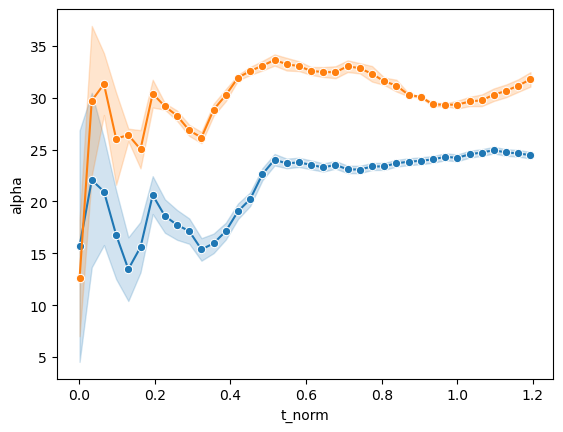

In [9]:
g=sns.lineplot(
data=DF1,
x='t_norm',
y='alpha',
estimator='mean',
errorbar='sd',      # 'sd' para desviación estándar, o 'ci' para intervalo de confianza
err_style='band',   # o 'bars' para barras verticales
marker='o'          # opcional para marcar puntos medios
)

g=sns.lineplot(
data=tl_df,
x='t_norm',
y='value',
estimator='mean',
errorbar='sd',      # 'sd' para desviación estándar, o 'ci' para intervalo de confianza
err_style='band',   # o 'bars' para barras verticales
marker='o'          # opcional para marcar puntos medios
)

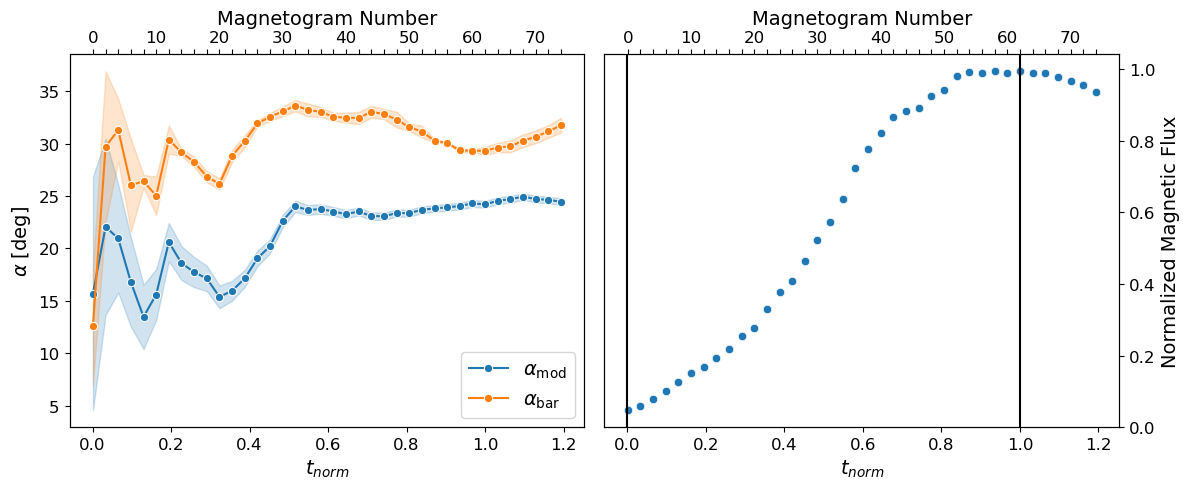

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# Left panel: lineplot with legend
sns.lineplot(
    data=DF1,
    x='t_norm',
    y='alpha',
    estimator='mean',
    errorbar='sd',
    err_style='band',
    marker='o',
    label=r'$\alpha_\mathrm{mod}$',
    ax=axes[0]
)
sns.lineplot(
    data=tl_df,
    x='t_norm',
    y='value',
    estimator='mean',
    errorbar='sd',
    err_style='band',
    marker='o',
    label=r'$\alpha_\mathrm{bar}$',
    ax=axes[0]
)
axes[0].legend(fontsize=14,loc='lower right')
axes[0].set_xlabel(r'$t_{norm}$', fontsize=14)
axes[0].set_ylabel(r'$\alpha$ [deg]', fontsize=14)
axes[0].tick_params(labelsize=12)

# Add top x-axis for mag numbers
ax_top = axes[0].twiny()
t_norms = tl_df.drop_duplicates('t_norm')[['t_norm', 'mag']].sort_values('t_norm')
ax_top.set_xlim(axes[0].get_xlim())
ax_top.set_xticks(t_norms['t_norm'])

# Mostrar solo cada 5 etiquetas
mag_labels = t_norms['mag'].astype(int).tolist()
mag_labels = [str(mag) if i % 5 == 0 else '' for i, mag in enumerate(mag_labels)]

ax_top.set_xticklabels(mag_labels, fontsize=12)
ax_top.set_xlabel('Magnetogram Number', fontsize=14)
ax_top.tick_params(axis='x', labelsize=12)


# Right panel: scatter plot t_norm vs flux from tl_df
sns.scatterplot(
    data=tl_df,
    x='t_norm',
    y='flux',
    ax=axes[1]
)
axes[1].set_xlabel(r'$t_{norm}$', fontsize=14)
axes[1].set_ylabel('Normalized Magnetic Flux', fontsize=14)
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].tick_params(labelsize=12)
axes[1].axvline(0,color='black')
axes[1].axvline(1,color='black')

# Add top x-axis for mag numbers
ax_top = axes[1].twiny()
t_norms = tl_df.drop_duplicates('t_norm')[['t_norm', 'mag']].sort_values('t_norm')
ax_top.set_xlim(axes[1].get_xlim())
ax_top.set_xticks(t_norms['t_norm'])

# Mostrar solo cada 5 etiquetas
mag_labels = t_norms['mag'].astype(int).tolist()
mag_labels = [str(mag) if i % 5 == 0 else '' for i, mag in enumerate(mag_labels)]

ax_top.set_xticklabels(mag_labels, fontsize=12)
ax_top.set_xlabel('Magnetogram Number', fontsize=14)
ax_top.tick_params(axis='x', labelsize=12)

plt.tight_layout()
plt.savefig('./plots/9290-tilt.pdf',dpi=300)

<AxesSubplot: xlabel='magnetogram', ylabel='flux'>

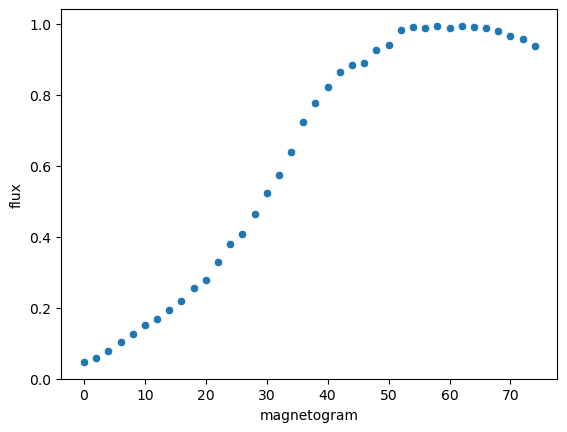

In [23]:
sns.scatterplot(data=tl_df,x='magnetogram',y='flux')

<AxesSubplot: xlabel='mag', ylabel='fn'>

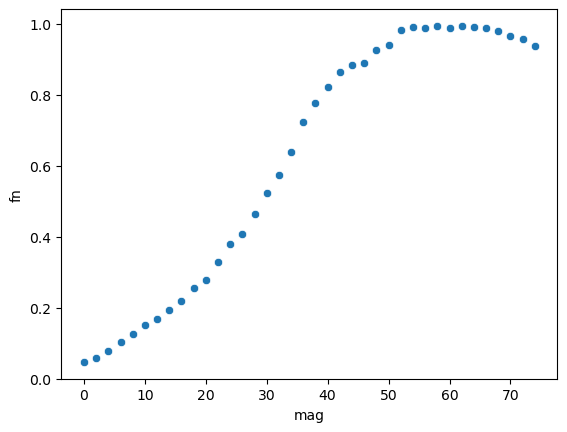

In [21]:
sns.scatterplot(data=DFx,x='mag',y='fn')


In [20]:
DFx

,AR,alpha,alphab,t_norm,lat,fn,mag,flux
0,9290,-0.273833,-7.862514,0.000911,30.0,0.047211,0.0,2.183354e+20
1,9290,-0.385162,-23.206690,0.033140,30.0,0.058581,2.0,2.709212e+20
2,9290,-0.365849,-29.266365,0.065368,30.0,0.078526,4.0,3.631599e+20
3,9290,-0.292983,-22.395872,0.097597,30.0,0.102882,6.0,4.757986e+20
4,9290,-0.235110,-26.406799,0.129826,30.0,0.125738,8.0,5.814984e+20
5,9290,-0.272255,-23.428815,0.162054,30.0,0.151754,10.0,7.018173e+20
6,9290,-0.359824,-29.133208,0.194283,30.0,0.168740,12.0,7.803705e+20
7,9290,-0.324598,-28.876365,0.226512,30.0,0.193407,14.0,8.944501e+20
8,9290,-0.309653,-27.565526,0.258740,30.0,0.219381,16.0,1.014570e+21
9,9290,-0.299175,-26.407381,0.290969,30.0,0.256058,18.0,1.184191e+21


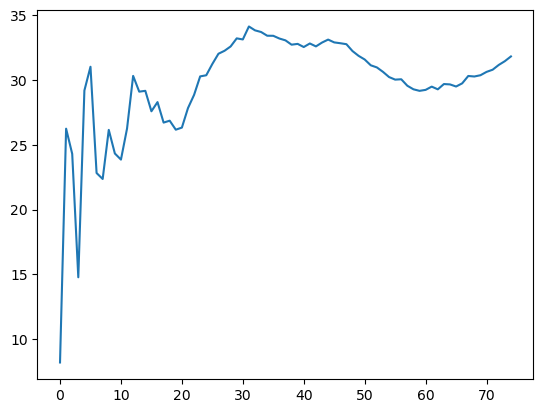

In [6]:
plt.plot(-1*np.mean(tl,axis=1))

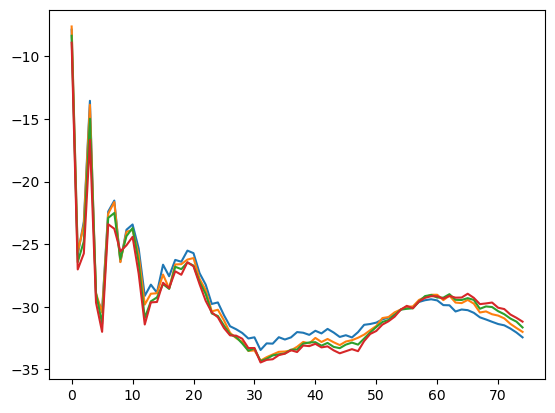

In [7]:
plt.plot(tl)